<a href="https://colab.research.google.com/github/shere-khan/machine_learning/blob/master/CNNCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# # create transformer for data augmentation
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ColorJitter(
#         brightness=0.2, contrast=.2, saturation=.2, hue=.2),
#     torchvision.transforms.RandomHorizontalFlip(p=.5),
#     torchvision.transforms.RandomRotation(degrees=15),
#     transforms.ToTensor()
#     )
# ])
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
# train_dataset = torchvision.datasets.FashionMNIST(
#     root='.',
#     train=True,
#     transform=transforms,
#     download=True
# )

In [ ]:
train_dataset.data.max()  

255

In [ ]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
train_dataset.targets

In [ ]:
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [ ]:
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified


In [ ]:
K = len(set(train_dataset.targets))
print(f'num classes: {K}')

num classes: 10


In [ ]:
# define model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # inspiration from VGG
    self.conv1 = nn.Sequential(
        # padding=1 is 'same' padding
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )

    # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
    # H_out = H_in + 2p - 2 -> p = 1 if H_out = H_in

    # easy to calculate output
    # 32 > 16 > 8 > 4
    
    # define FC layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=.2)
    x = self.fc2(x)
    return x

In [ ]:
model = CNN(K)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# data loader
# useful because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
                                          
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
def batchgd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimzie
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # get train/test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      # move data to gpu
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"""Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f},
    Test Loss: {test_loss:.4f}, Duration: {dt}""")

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batchgd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15
)

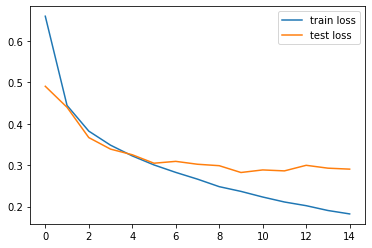

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  #reshape the input
  inputs = inputs.view(-1, 784)

  # forward pass
  outputs = model(inputs)

  # get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total
                  
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  #reshape the input
  inputs = inputs.view(-1, 784)

  # forward pass
  outputs = model(inputs)

  # get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f'train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('normalized conf mat')
  else:
    print('non-normalized conf mat')
    
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('true label')
  plt.xlabel('predicted label')
  plt.show()

non-normalized conf mat
[[804   2  27  17   2   1 137   0  10   0]
 [  0 976   1  14   2   0   5   0   2   0]
 [  8   0 893   7  46   0  44   0   2   0]
 [  8   3  23 887  42   0  32   0   5   0]
 [  0   0  46  20 880   0  53   0   1   0]
 [  0   0   0   2   0 979   0  12   1   6]
 [ 80   0  81  25  96   0 703   0  15   0]
 [  0   0   0   0   0  24   0 942   1  33]
 [  0   0   4   2   5   1   2   1 985   0]
 [  1   0   0   0   0   9   0  24   2 964]]


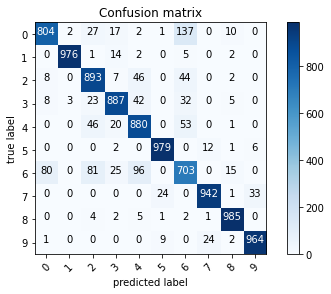

In [ ]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Snearker
Bag
Ankle boot'''.split('\n')

Text(0.5, 1.0, 'True label: Pullover Predicted: Shirt')

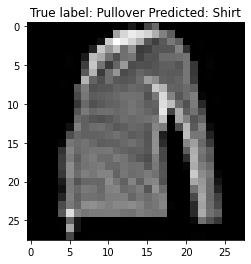

In [ ]:
# show some misclassified samples

p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.title(f'True label: %s Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))